# Low-frequency component analysis of SST

Reading in SST data and performing low-frequency component analysis

In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
#import cftime

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

## Using `intake-esm` to get SST data
[Intake-esm](https://intake-esm.readthedocs.io) is a data cataloging utility that facilitates access to CMIP data. It's pretty awesome.

An `intake-esm` collection object establishes a link to a database that contains file locations and associated metadata (i.e. which experiement, model, etc. thet come from). 

### Opening a collection
First step is to open a collection by pointing to the collection definition file, which is a JSON file that conforms to the [ESM Collection Specification](https://github.com/NCAR/esm-collection-spec). 

The collection JSON files are stored locally in this repository for purposes of reproducibility---and because Cheyenne compute nodes don't have Internet access. 

The primary source for these files is the [intake-esm-datastore](https://github.com/NCAR/intake-esm-datastore) repository. Any changes made to these files should be pulled from that repo. For instance, the Pangeo cloud collection is available [here](https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json).

In [2]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
#col

`intake-esm` is build on top of [pandas](https://pandas.pydata.org/pandas-docs/stable). It is possible to view the `pandas.DataFrame` as follows.

In [3]:
#col.df.head()

It is possible to interact with the `DataFrame`; for instance, we can see what the "attributes" of the datasets are by printing the columns.

In [4]:
#col.df.columns

### Search and discovery

#### Finding unique entries
Let's query the data to see what models ("source_id"), experiments ("experiment_id") and temporal frequencies ("table_id") are available.

In [5]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

#### Searching for specific datasets

Let's find all the dissolved oxygen data at annual frequency from the ocean for the `historical` and `ssp585` experiments.

In [6]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Amon', variable_id='ts', grid_label='gn')
#cat.df

It might be desirable to get more specific. For instance, we may want to select only the models that have *both* `historical` and `ssp585` data. We coud do this as follows.

In [7]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical', 'ssp585']:
    query = dict(experiment_id=experiment_id, table_id='Amon', 
                 variable_id='ts', grid_label='gn')  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

models = list(models)
models

['FGOALS-g3',
 'CAMS-CSM1-0',
 'MIROC-ES2L',
 'CanESM5',
 'MRI-ESM2-0',
 'UKESM1-0-LL',
 'NESM3',
 'BCC-CSM2-MR',
 'MIROC6']

In [8]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Amon', 
                 variable_id='ts', grid_label='gn', source_id=models)
#cat.df

### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [9]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': True})


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 18 group(s)


`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [10]:
dset_dict.keys()

dict_keys(['CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn', 'CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn', 'CMIP.CAS.FGOALS-g3.historical.Amon.gn', 'CMIP.CAS.FGOALS-g3.ssp585.Amon.gn', 'CMIP.CCCma.CanESM5.historical.Amon.gn', 'CMIP.MIROC.MIROC-ES2L.historical.Amon.gn', 'CMIP.MIROC.MIROC6.historical.Amon.gn', 'CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn', 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn', 'CMIP.NUIST.NESM3.historical.Amon.gn', 'ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.Amon.gn', 'ScenarioMIP.CAMS.CAMS-CSM1-0.ssp585.Amon.gn', 'ScenarioMIP.CCCma.CanESM5.ssp585.Amon.gn', 'ScenarioMIP.MIROC.MIROC-ES2L.ssp585.Amon.gn', 'ScenarioMIP.MIROC.MIROC6.ssp585.Amon.gn', 'ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.Amon.gn', 'ScenarioMIP.MRI.MRI-ESM2-0.ssp585.Amon.gn', 'ScenarioMIP.NUIST.NESM3.ssp585.Amon.gn'])

We can access a particular dataset as follows.

In [11]:
# choose model here
ds_hist = dset_dict['CMIP.CCCma.CanESM5.historical.Amon.gn']
ds_ssp585 = dset_dict['ScenarioMIP.CCCma.CanESM5.ssp585.Amon.gn']

### Get land fraction

As motivation for diving into more advanced manipulations with `intake-esm`, let's consider the task of getting access to grid information in the `Ofx` table_id.

In [12]:
cat_fx = col.search(experiment_id=['historical'], source_id=models, variable_id='sftlf', table_id='fx', grid_label='gn')
#cat_fx.df

In [13]:
df = cat_fx.df.copy()
df.drop_duplicates(subset=['source_id', 'variable_id'], inplace=True)
#df

Now, since we've only retained one ensemble member, we need to eliminate that column. If we omit this step, `intake-esm` will throw an error, complaining that different variables are present for each ensemble member. Setting the `member_id` column to NaN precludes attempts to join along the ensemble dimension.

After this final manipulation, we copy the `DataFrame` back to the collection object and proceed with loading the data.

In [14]:
df['member_id'] = np.nan
cat_fx.df = df

In [15]:
fx_dsets = cat_fx.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


In [16]:
fx_dsets.keys()

dict_keys(['CMIP.MIROC.MIROC6.historical.fx.gn', 'CMIP.MRI.MRI-ESM2-0.historical.fx.gn'])

In [17]:
for key, ds in fx_dsets.items():
    print(ds.data_vars)

Data variables:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
    type      |S4 ...
    sftlf     (lat, lon) float32 dask.array<chunksize=(128, 256), meta=np.ndarray>
Data variables:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(160, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(320, 2), meta=np.ndarray>
    type      |S4 ...
    sftlf     (lat, lon) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>


In [18]:
# Low-frequency component analysis on loaded data

lat=ds_hist['lat']
lon=ds_hist['lon']

In [19]:
members = ds_hist['member_id']
ne = np.shape(members)
ne

(44,)

In [20]:
members[0].values

array('r2i1p1f1', dtype='<U9')

In [24]:
ds_ssp585.time

<xarray.DataArray 'time' (time: 1992)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, 0, 16),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, 2, 46),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, 3, 75), ...,
       cftime.DatetimeNoLeap(2180, 10, 16, 12, 0, 0, 0, 4, 289),
       cftime.DatetimeNoLeap(2180, 11, 16, 0, 0, 0, 0, 0, 320),
       cftime.DatetimeNoLeap(2180, 12, 16, 12, 0, 0, 0, 2, 350)], dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2180-12-16 12:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [22]:
hist_clim=ds_hist.groupby('time.month').mean('time')
ssp585_clim=ds_ssp585.groupby('time.month').mean('time')

hist_clim_emean = hist_clim.mean('member_id')
ssp585_clim_emean = ssp585_clim.mean('member_id')

hist_anom = ds_hist.groupby('time.month') - hist_clim
ssp585_anom = ds_ssp585.groupby('time.month') - ssp585_clim

hist_anom_emean = hist_anom.mean('member_id')
ssp585_anom_emean = ssp585_anom.mean('member_id')

/glade/u/home/rwills/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]
/glade/u/home/rwills/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 166 times more chunks
  return self.array[key]
/glade/u/home/rwills/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 83 times more chunks
  return self.array[key]


In [23]:
field = ssp585_anom_emean.ts.values

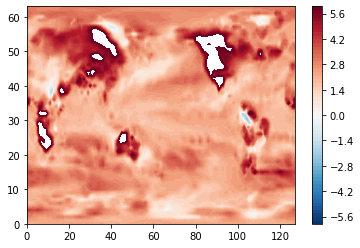

In [29]:
f=plt.figure()
plt.contourf(field[1991,:,:],np.arange(-6,6.2,.2),cmap=plt.cm.RdBu_r)
plt.colorbar()

In [52]:
ts_hist_emean = ds_hist.ts.mean('member_id')
ts_ssp585_emean = ds_ssp585.ts.mean('member_id')

In [ ]:
ds_hist_anom=ds_hist-ds_hist.ts.sel(year=slice(1964,2014)).mean('year')

In [ ]:
plot(lon,lat,ts_hist_emean)

In [36]:
# Preprocessing for Large Ensemble EOFs (with upscaling)

cosw = np.sqrt(np.cos(lat*np.pi/180))

X=hist_anom*cosw

X_flat=X.stack(index=['time','member_id'])
X_ensmean=X.mean('member_id')

T = X_flat.time

#upscaling
X_upscale = util.upscale(lat,lon,X_flat,2)

X_upscale_flat = X_upscale.stack(shape=['lat','lon'])
#sh1=np.shape(ds_upscale)
#ds_upscale_flat=np.reshape(ds_upscale,[sh1[0]*sh1[1],sh1[2]])

latu = X_upscale.lat.values
lonu = X_upscale.lon.values

/glade/u/home/rwills/miniconda3/lib/python3.7/site-packages/xarray/core/dataset.py:2648: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  v.labels,


In [ ]:
%%time

# Large Ensemble EOFs (with upscaling)

#ds_ensmean_upscale = upscale(lat.values,lon.values,ds_ensmean.values.transpose(1,2,0),2)
ds_ensmean_upscale = upscale2(lat,lon,ds_ensmean,2)

ds_ensmean_upscale_flat = ds_ensmean_upscale.stack(shape=['lat','lon'])
#sh1=np.shape(ds_ensmean_upscale)
#ds_ensmean_upscale_flat=np.reshape(ds_ensmean_upscale,[sh1[0]*sh1[1],sh1[2]])

u,s,v=np.linalg.svd(ds_upscale_flat.values.T/np.sqrt(len(T)-1))

eigvals=np.diag(s*s)

cosw = np.sqrt(np.cos(latu*np.pi/180))

# Dimension checks
#print(ds_upscale.shape)
#plt.contourf(ds_upscale.lon,ds_upscale.lat,ds_upscale[0,0,:,:])
#ds_upscale.lat_bins

In [29]:
hist_anom

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 64, lon: 128, member_id: 44, month: 12, time: 1980)
Coordinates:
  * member_id  (member_id) <U9 'r2i1p1f1' 'r5i1p1f1' ... 'r18i1p1f1' 'r6i1p1f1'
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (lon, bnds, month) float64 dask.array<chunksize=(128, 2, 1), meta=np.ndarray>
    lat_bnds   (lat, bnds, month) float64 dask.array<chunksize=(64, 2, 1), meta=np.ndarray>
    ts         (member_id, time, lat, lon, month) float32 dask.array<chunksize=(1, 1980, 64, 128, 1), meta=np.ndarray>